In [2]:
import pandas as pd
import ast
from fuzzywuzzy import process, fuzz
import h5py
from ediblepickle import checkpoint
from urllib.parse import quote
import glob
import pickle
import openai

In [4]:
recipe_df = pd.read_csv('Recipe/recipes_w_search_terms.csv')
nutrition_df = pd.read_csv('nutrition_2/nutrition.csv')

In [5]:
catrgories_food101 = pd.read_csv('food101/meta/meta/classes.txt')

# Match food categories from image label to recipe

In [6]:
cache_dir = 'cache'
@checkpoint(key=lambda args, kwargs: quote(args[0]) + '_recipy_ind.pkl', work_dir=cache_dir)
def get_recipe(food_name):
    choices = recipe_df['name'].tolist()
    match, score = process.extractOne(food_name, choices, scorer=fuzz.WRatio, score_cutoff=70)
    
    # Check if a match is found with a score above the threshold (adjust the threshold as needed)
    if match is not None:
        return choices.index(match)
    else:
        print(f"No match found for {food_name}")
        return None
    
index_101food = []
for c in catrgories_food101.values:
    print(c[0])
    index_101food.append(get_recipe(c[0]))

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito
bruschetta
caesar_salad
cannoli
caprese_salad
carrot_cake
ceviche
cheesecake
cheese_plate
chicken_curry
chicken_quesadilla
chicken_wings
chocolate_cake
chocolate_mousse
churros
clam_chowder
club_sandwich
crab_cakes
creme_brulee
croque_madame
cup_cakes
deviled_eggs
donuts
dumplings
edamame
eggs_benedict
escargots
falafel
filet_mignon
fish_and_chips
foie_gras
french_fries
french_onion_soup
french_toast
fried_calamari
fried_rice
frozen_yogurt
garlic_bread
gnocchi
greek_salad
grilled_cheese_sandwich
grilled_salmon
guacamole
gyoza
hamburger
hot_and_sour_soup
hot_dog
huevos_rancheros
hummus
ice_cream
lasagna
lobster_bisque
lobster_roll_sandwich
macaroni_and_cheese
macarons
miso_soup
mussels
nachos
omelette
onion_rings
oysters
pad_thai
paella
pancakes
panna_cotta
peking_duck
pho
pizza
pork_chop
poutine
prime_rib
pulled_pork_sandwich
ramen
ravioli
red_velvet_cake
risotto
sa

In [7]:
indices_to_extract = []
files = glob.glob('cache/*.pkl')
for cashed_file in files:
    with open(cashed_file, 'rb') as f:
        indices_to_extract.append(pickle.load(f))

In [8]:
df_food101_to_recipe = recipe_df.loc[indices_to_extract]


In [9]:
df_food101_to_recipe.to_csv('food101_to_recipe.csv')

# Go through food recipe and fix poorly matched entries

In [10]:
food_recipe = pd.read_csv('food101_to_recipe.csv')

In [11]:
check_cat = pd.DataFrame([food_recipe['name'], catrgories_food101['Classes']]).T

In [12]:
n = 100
check_cat[n:n+10] 
# '0: apple pie' 
# '41: french onion soup' 
# '45 frozen yogurt' 
# '54 hot and sour soup'
# '61 lobster_roll_sandwich' 
# '62 macaroni_and_cheese' 
# '75 pho' 
# '77 pork chop' 
# '80 pulled_pork_sandwich' 
# '81 ramen'
# '86 sashimi' 
# '87 scallops'  
# '89 shrimp_and_grits'

,name,Classes
100,Waffles,waffles


In [13]:
correction_0 = recipe_df[recipe_df['name'].str.contains('apple pie', case=False)]
correction_41 = recipe_df[recipe_df['name'].str.contains('french onion soup', case=False)]
correction_45 = recipe_df[recipe_df['name'].str.contains('frozen yogurt', case=False)]
correction_54 = recipe_df[recipe_df['name'].str.contains('hot and sour soup', case=False)]
correction_61 = recipe_df[recipe_df['name'].str.contains('lobster roll sandwich', case=False)]
correction_62 = recipe_df[recipe_df['name'].str.contains('macaroni and cheese', case=False)]


In [14]:
correction_75 = recipe_df[recipe_df['name'].str.contains('pho ', case=False)]
correction_77 = recipe_df[recipe_df['name'].str.contains('pork chop', case=False)]
correction_80 = recipe_df[recipe_df['name'].str.contains('pulled pork sandwich', case=False)]
correction_81 = recipe_df[recipe_df['name'].str.contains('ramen', case=False)]
correction_86 = recipe_df[recipe_df['name'].str.contains('sashimi', case=False)]
correction_87 = recipe_df[recipe_df['name'].str.contains('scallop ', case=False)]
correction_89 = recipe_df[recipe_df['name'].str.contains('shrimp and grits ', case=False)]


In [15]:
food_recipe.loc[0] = correction_0.loc[1726]
food_recipe.loc[41] = correction_41.loc[5082]
food_recipe.loc[45] = correction_45.loc[72]
food_recipe.loc[54] = correction_54.loc[28287]
food_recipe.loc[61] = correction_61.loc[264472]
food_recipe.loc[62] = correction_62.loc[1429]
food_recipe.loc[75] = correction_75.loc[27729]
food_recipe.loc[80] = correction_80.loc[19760]
food_recipe.loc[81] = correction_81.loc[1512]
food_recipe.loc[86] = correction_86.loc[162062]
food_recipe.loc[87] = correction_87.loc[2515]
food_recipe.loc[89] = correction_89.loc[105604]

In [16]:
food_recipe['Classes'] = catrgories_food101['Classes']

In [17]:
food_recipe_df = food_recipe[['Classes','name', 'ingredients', 'ingredients_raw_str', 'servings']]
food_recipe_df['ingredients_raw_str'] = food_recipe_df['ingredients_raw_str'].apply(ast.literal_eval)
food_recipe_df['ingredients'] = food_recipe_df['ingredients'].apply(ast.literal_eval)

/tmp/ipykernel_303214/3911693687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_recipe_df['ingredients_raw_str'] = food_recipe_df['ingredients_raw_str'].apply(ast.literal_eval)
/tmp/ipykernel_303214/3911693687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_recipe_df['ingredients'] = food_recipe_df['ingredients'].apply(ast.literal_eval)


# Get ingredients and the amount

In [18]:
units_list = [
    'ounce', ' oz ',
    'gram', ' g ',
    'pound', ' lb ',
    'milligram', ' mg ',
    'kilogram', ' kg ',
    'teaspoon', 'tsp',
    'tablespoon', 'tbsp',
    'fluid ounce', 'fl oz',
    'cup', ' c ',
    'pint', ' pt ',
    'quart', ' qt ',
    'gallon', ' gal ',
    'milliliter', ' ml ',
    'liter', 
    'handful'
]


def get_amount(ingredients_raw):
    amount = []
    failed_ind = []

    for i, s in enumerate(ingredients_raw):
            
        s = s.split()
        
        # if the first element is not a number
        try:
            eval(s[0])
        except:
            amount.append('')
            failed_ind.append(i)
            continue

            
        # if the second element is not a unit
        found_unit = False
        for unit_element in units_list:
            if s[1] in unit_element or unit_element in s[1]:
                found_unit = True
                unit = (min(s[1], unit_element))
                amount.append([s[0], unit])
                break
        if not found_unit:
            amount.append('')
            failed_ind.append(i)
    return amount, failed_ind

In [19]:
# remove empty strings
filtered_ingredients = [list(filter(None, recipe)) for recipe in food_recipe_df['ingredients_raw_str']]


In [20]:
amounts = []
failed_inds = []
for recipe in filtered_ingredients:
    amount, failed_ind = get_amount(recipe)
    amounts.append(amount)
    failed_inds.append(failed_ind)
    

In [21]:
#  check for number of ingredients
import numpy as np
a = []
for i in range(101):
    a.append(len(filtered_ingredients[i]) == len(food_recipe_df['ingredients'][i]))
print(np.mean(a))

1.0


In [22]:
# for the failed ingredients above, try getting the amount from chatgpt

import os
openai.api_key_path = os.getenv('openai_key_food101')

def get_amount_openai(s):
    prompt = f'''for the below sentence, please give me a rough estimate of the weight of the food.
        if not able to estimate, tell me 'N/A'. 
        keep the output strictly within 2 words like 'n grams' or 'N/A': : '{s}'.'''

    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
              {"role": "user", "content": prompt}]
    )

    # Extract amount and unit from the generated response
    res = response.choices[0].message.content.strip().split()
    print(res)
    print('\n')

    return res


In [23]:
for food_ind in range(101):
    for ingredient_ind in failed_inds[food_ind]:
        print(filtered_ingredients[food_ind][ingredient_ind])
        try_get_amount = get_amount_openai(filtered_ingredients[food_ind][ingredient_ind])
        if try_get_amount[0] in 'N/A.':
            continue
        if len(try_get_amount) == 2:
            amounts[food_ind][ingredient_ind] = try_get_amount
        else:
            continue

1       pastry crust (Pillsbury)
['N/A']


6   large   mcintosh apples (cored and peeled)
['600', 'grams']


4 -5   lbs    lean pork spareribs
['2', 'kilograms']


14       phyllo pastry sheets
['150', 'grams']


2   lbs   topside of aberdeen angus beef or 2   lbs    prime rib roast
['4', 'lbs']


  fresh ground black pepper, to taste 
['N/A']


4       garlic cloves, chopped 
['10', 'grams']


1   bunch    fresh basil
['N/A']


1/2  bunch    fresh thyme
['N/A']


15       black peppercorns, crushed 
['5', 'grams']


1 1/4  cups    dry white wine
['N/A']


2 1/2  cups    olive oil
['N/A']


2       shallots, diced 
['10', 'grams']


  green chili sauce, such as Tabasco 
['N/A']


  salt & freshly ground black pepper
['N/A']


  canola oil, for frying 
['N/A']


6       parsnips, peeled and julienned 
['N/A']


 smoked salt
['N/A']


  fresh ground black pepper
['N/A']


2       eggs, hard-cooked and chopped 
['60', 'grams']


1   package    active dry yeast
['N/A']


1 1/2  cups    war

['5', 'grams']


2   slices    white bread
['100', 'grams']


1   slice    American cheese
['20', 'grams']


1   slice    cheddar cheese
['N/A']


  cream cheese, light is okay 
['N/A']


  butter
['N/A']


6       salmon fillets
['900', 'grams']


2       avocados
['180', 'grams']


1       green onion, minced 
['10', 'grams']


1      dried black mushroom, soaked in 2 tb water 
['5', 'grams']


2 -3   tablespoons    peanut oil
['15-20', 'grams']


1   package    gyoza skins or 1   package    wonton wrapper
['N/A']


1   dash    sesame oil
['N/A']


  sea salt
['N/A']


  fresh ground black pepper
['N/A']


3   slices   aged Vermont sharp cheddar cheese
['150', 'grams']


3       kaiser rolls, sliced 
['600', 'grams']


1       tomatoes, sliced 
['N/A']


1       onion, texas sweet sliced 
['40', 'grams']


6   slices   clausen pickles
['N/A']


  stone ground mustard
['N/A']


4 -6       dried Chinese mushrooms, soaked 
['30', 'grams']


1   package    firm tofu
['N/A']


2 1/2  cups

['N/A']


  cocoa powder, for dusting 
['N/A']


12       wonton wrappers (can substitute egg roll wrappers)
['100', 'grams']


1       garlic clove, minced 
['5', 'grams']


1       avocado, cut into 1/4-inch dice 
['100', 'grams']


  fresh cilantro stem (to garnish)
['N/A']


1       egg
['50', 'grams']


1   pinch    salt
['N/A']




### convert to grams assuming density of water

In [24]:
def convert_to_grams(val, unit):
    conversion_factors = {
        'ounce': 28.3495,
        'ounces': 28.3495,
        'oz': 28.3495,
        'gram': 1,
        'grams': 1,
        'grams.': 1,
        'g': 1,
        'pound': 453.592,
        'pounds': 453.592,
        'lb': 453.592,
        'lbs': 453.592,
        'lbs.': 453.592,
        'milligram': 0.001,
        'mg': 0.001,
        'kilogram': 1000,
        'kilograms': 1000,
        'kg': 1000,
        'teaspoon': 4.92892,
        'tsp': 4.92892,
        'tablespoon': 14.7868,
        'tbsp': 14.7868,
        'fluid ounce': 29.5735,  # For water, this is approximately equal to grams
        'fl oz': 29.5735,
        'cup': 236.588,  # Assuming a cup of water weighs 236.588 grams
        'c': 236.588,
        'pint': 473.176,  # Assuming a pint of water weighs 473.176 grams
        'pt': 473.176,
        'quart': 946.353,  # Assuming a quart of water weighs 946.353 grams
        'qt': 946.353,
        'gallon': 3785.41,  # Assuming a gallon of water weighs 3785.41 grams
        'gal': 3785.41,
        'milliliter': 1,  # Assuming water density, 1 milliliter = 1 gram
        'ml': 1,
        'liter': 1000,  # Assuming water density, 1 liter = 1000 grams
        'handful': 5  
    }
    
    # If the unit is in the conversion factors dictionary, convert to grams
    unit = unit.lower().strip()
    if unit in conversion_factors:
        return val * conversion_factors[unit]
    else:
        return ''  

In [25]:
weight = []
for i in range(101):
    
    amount_in_g = []
    for l in amounts[i]:
        if not l:
            amount_in_g.append('')
        else:
            amount_in_g.append(convert_to_grams(eval(l[0]), l[1]))
    weight.append(amount_in_g)

In [26]:
food_recipe_df['weights'] = weight

/tmp/ipykernel_303214/1767175141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_recipe_df['weights'] = weight


In [27]:
food_recipe_df.to_csv('food_recipe_df.csv')

# Map nutrients to ingredients

In [28]:
# Flatten the 2D list in the 'ingredients' column
flat_ingredients = [ing for sublist in food_recipe['ingredients'].apply(ast.literal_eval) for ing in sublist]

# Get unique ingredients
unique_ingredients = pd.unique(flat_ingredients)



In [29]:
choices = nutrition_df['name'].tolist()
unmatched = []
cache_dir = 'cache_ingredient_2'
@checkpoint(key=lambda args, kwargs: quote(args[0]) + '_ingredient_ind.pkl', work_dir=cache_dir)
def get_ingredient(ingredient):
    try:
        match, score = process.extractOne(ingredient, choices, scorer=fuzz.WRatio, score_cutoff=70)
        return [choices.index(match), ingredient]
    except TypeError:
        unmatched.append(ingredient)
        print('!!!!!'+ingredient)
    

    
index_ingredient = []
for c in unique_ingredients:
    print(c)
    index_ingredient.append(get_ingredient(c))

sugar
light brown sugar
flour
cinnamon
pastry crust
apples
lemon juice
butter
lean pork spareribs
dark soy sauce
hoisin sauce
bottled chili sauce
liquid honey
brandy
fresh ginger
fresh garlic
coarse black pepper
honey
water
orange rind
orange juice
phyllo pastry sheets
almonds
beef
fresh ground black pepper
parmesan cheese
balsamic vinegar
soy sauce
worcestershire sauce
garlic cloves
fresh basil
fresh thyme
black peppercorns
dry white wine
olive oil
coarse sea salt
beef tenderloin
parmigiano-reggiano cheese
garlic-stuffed olives
dijon mustard
shallots
celery leaves
fresh chives
fresh parsley
green chili sauce
salt %26 freshly ground black pepper
canola oil
parsnips
salt
beets
celery
red onion
eggs
dill pickle
celery seed
black pepper
red wine vinegar
salad oil
active dry yeast
warm water
evaporated milk
vegetable shortening
oil
confectioners%27 sugar
sesame oil
garlic clove
ginger
apple juice
lean ground beef
short-grain rice
zucchini
mushroom
bean sprouts
carrot
chili paste
rice wine 

In [30]:
indices_to_extract = []
ingredient = []
files = glob.glob('cache_ingredient_2/*.pkl')
for cashed_file in files:
    with open(cashed_file, 'rb') as f:
        try:
            ind, ing = pickle.load(f)
            indices_to_extract.append(ind)
            ingredient.append(ing)
        except:
            continue

In [31]:
ingredient_nutri = nutrition_df.loc[indices_to_extract].copy()
ingredient_nutri['ing_name'] = ingredient
ingredient_nutri = ingredient_nutri[['ing_name', 'serving_size', 'vitamin_a', 'vitamin_d', 'vitamin_e', 'vitamin_c', 'thiamin', 'riboflavin', 'niacin', 'vitamin_b6', 'vitamin_b12', 'folic_acid', 'calcium', 'irom', 'protein', 'zink']]
ingredient_nutri.to_csv('ingredient_nutri.csv')

In [32]:
ingredient_nutri = pd.read_csv('ingredient_nutri.csv', index_col=0)
ingredient_nutri.set_index('ing_name', inplace=True)

In [33]:
# add unmatched ingredients manully
nutritional_content = {
    'ing_name': ['crabmeat', 'panko breadcrumbs', 'baguette', 'calamari', 'linguine'],
    'serving_size':['100 g', '100 g', '100 g', '100 g', '100 g'],
    'vitamin_a': ['100 IU', '0 IU', '0 IU', '50 IU', '0 IU'],  
    'vitamin_d': ['0.06 mcg', '0 mcg', '0 mcg', '0.8 mcg', '0 mcg'],
    'vitamin_e': ['0.3 mg', '0.45 mg', '0.25 mg', '0.8 mg', '0.2 mg'],
    'vitamin_c': ['10 mg', '0 mg', '0 mg', '5 mg', '0 mg'],    
    'thiamin': ['0.1 mg', '0 mg', '0.05 mg', '0.2 mg', '0.1 mg'],  
    'riboflavin': ['0.2 mg', '0 mg', '0.1 mg', '0.3 mg', '0.2 mg'],  
    'niacin': ['2 mg', '0 mg', '1 mg', '1.5 mg', '2 mg'],  
    'vitamin_b6': ['0.2 mg', '0 mg', '0.1 mg', '0.3 mg', '0.2 mg'],  
    'vitamin_b12': ['1 mcg', '0 mcg', '0.5 mcg', '2 mcg', '1 mcg'],  
    'folic_acid': ['50 mcg', '0 mcg', '20 mcg', '30 mcg', '40 mcg'],  
    'calcium': ['100 mg', '0 mg', '50 mg', '50 mg', '30 mg'], 
    'irom': ['2 mg', '0 mg', '1 mg', '2.5 mg', '2 mg'],  
    'protein': ['15 g', '10 g', '8 g', '20 g', '12 g'],  
    'zink': ['1 mg', '0 mg', '0.5 mg', '2 mg', '1 mg']  
}
extend_ing = pd.DataFrame(nutritional_content)
extend_ing.set_index('ing_name', inplace=True)
ingredient_nutri = pd.concat([ingredient_nutri, extend_ing])

In [34]:
ingredient_nutri


,serving_size,vitamin_a,vitamin_d,vitamin_e,vitamin_c,thiamin,riboflavin,niacin,vitamin_b6,vitamin_b12,folic_acid,calcium,irom,protein,zink
ing_name,,,,,,,,,,,,,,,
sugar,100 g,0.00 IU,0.00 IU,0.00 mg,0.0 mg,0.000 mg,0.000 mg,0.000 mg,0.000 mg,0.00 mcg,0.00 mcg,20.00 mg,0.00 mg,0.00 g,0.00 mg
light brown sugar,100 g,206.00 IU,49.00 IU,0,0.0 mg,0,0.210 mg,0,0,1.23 mcg,0,123.00 mg,0.59 mg,2.06 g,0.25 mg
flour,100 g,0.00 IU,0.00 IU,0,0.0 mg,0.457 mg,0.172 mg,11.499 mg,0.304 mg,0.00 mcg,0.00 mcg,130.00 mg,4.74 mg,33.80 g,5.99 mg
cinnamon,100 g,4.00 IU,0.00 IU,0.50 mg,0.0 mg,0.317 mg,0.120 mg,2.822 mg,0.027 mg,0.05 mcg,36.00 mcg,71.00 mg,2.54 mg,7.05 g,0.49 mg
pastry crust,100 g,128.00 IU,2.00 IU,0.35 mg,0.1 mg,0.190 mg,0.260 mg,2.000 mg,0.040 mg,0.20 mcg,35.00 mcg,35.00 mg,1.80 mg,8.00 g,0.70 mg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
crabmeat,100 g,100 IU,0.06 mcg,0.3 mg,10 mg,0.1 mg,0.2 mg,2 mg,0.2 mg,1 mcg,50 mcg,100 mg,2 mg,15 g,1 mg
panko breadcrumbs,100 g,0 IU,0 mcg,0.45 mg,0 mg,0 mg,0 mg,0 mg,0 mg,0 mcg,0 mcg,0 mg,0 mg,10 g,0 mg
baguette,100 g,0 IU,0 mcg,0.25 mg,0 mg,0.05 mg,0.1 mg,1 mg,0.1 mg,0.5 mcg,20 mcg,50 mg,1 mg,8 g,0.5 mg


In [35]:
# check units:
def check_units(column):
    units = [value.split()[1] for value in column if value != '0']
    return len(set(units)) == 1

# Apply the function to each column
unit_check = ingredient_nutri.apply(check_units)
print(unit_check)

serving_size     True
vitamin_a       False
vitamin_d       False
vitamin_e        True
vitamin_c        True
thiamin          True
riboflavin       True
niacin           True
vitamin_b6       True
vitamin_b12      True
folic_acid       True
calcium          True
irom             True
protein          True
zink             True
dtype: bool


In [36]:
units = set()
for value in ingredient_nutri['vitamin_a']:
    if value != '0':
        units.add(value.split(' ')[1])
print(units)

{'mcg', 'IU'}


In [37]:
units = set()
for value in ingredient_nutri['vitamin_d']:
    if value != '0':
        units.add(value.split(' ')[1])
print(units)

{'mcg', 'IU'}


In [38]:
# convert IU to mcg
vitamin_a_mcg = []
for item in ingredient_nutri['vitamin_a']:
    if item == '0':
        vitamin_a_mcg.append(item)
    elif item.split()[-1] == 'IU':
        vitamin_a_mcg.append(str(eval(item.split()[0]) * 0.3) + ' mcg')
    else:
        vitamin_a_mcg.append(item)
        


In [39]:
ingredient_nutri['vitamin_a'] = vitamin_a_mcg

In [40]:
# convert IU to mcg
vitamin_d_mcg = []
for item in ingredient_nutri['vitamin_d']:
    if item == '0':
        vitamin_d_mcg.append(item)
    elif item.split()[-1] == 'IU':
        vitamin_d_mcg.append(str(eval(item.split()[0]) * 0.025) + ' mcg')
    else:
        vitamin_d_mcg.append(item)
        


In [41]:
ingredient_nutri['vitamin_d'] = vitamin_d_mcg

# Calculate nutrients of each recipe

In [42]:

def get_all_nutri(food_ind):
    va = 0
    vd = 0
    ve = 0
    vc = 0
    thia = 0
    ribo = 0
    nia = 0
    vb6 = 0
    vb12 = 0
    folic = 0
    cal = 0
    iro = 0
    prot = 0
    zink = 0
    
    ingres = food_recipe_df.iloc[food_ind]['ingredients']
    weight = food_recipe_df.iloc[food_ind]['weights']
    servings = food_recipe_df.iloc[food_ind]['servings']
    
    for i, ingre in enumerate(ingres):
        w = weight[i]
#         print(ingre)
        if not ingre or not w:
            continue
        ingre = ingre.lower().strip()
        nutri_list = ingredient_nutri.loc[ingre]
        va += eval(nutri_list['vitamin_a'].split()[0]) / 100.0 * w / servings
        vd += eval(nutri_list['vitamin_d'].split()[0]) / 100.0 * w / servings
        ve += eval(nutri_list['vitamin_e'].split()[0]) / 100.0 * w / servings
        vc += eval(nutri_list['vitamin_c'].split()[0]) / 100 * w / servings
        thia += eval(nutri_list['thiamin'].split()[0]) / 100 * w / servings
        ribo += eval(nutri_list['riboflavin'].split()[0]) / 100 * w / servings
        nia += eval(nutri_list['niacin'].split()[0]) / 100 * w / servings
        vb6 += eval(nutri_list['vitamin_b6'].split()[0]) / 100 * w / servings
        vb12 += eval(nutri_list['vitamin_b12'].split()[0]) / 100 * w / servings
        folic += eval(nutri_list['folic_acid'].split()[0]) / 100 * w / servings
        cal += eval(nutri_list['calcium'].split()[0]) / 100 * w / servings
        iro += eval(nutri_list['irom'].split()[0]) / 100 * w / servings
        prot += eval(nutri_list['protein'].split()[0]) / 100 * w / servings
        zink += eval(nutri_list['zink'].split()[0]) / 100 * w / servings

         
    return [va, vd, ve, vc, thia, ribo, nia, vb6, vb12, folic, cal, iro, prot, zink]
    
    

In [43]:
vitamin_a_per_serving = []
vitamin_d_per_serving = []
vitamin_e_per_serving = []
vitamin_c_per_serving = []
thiamin_per_serving = []
riboflavin_per_serving = []
niacin_per_serving = []
vitamin_b6_per_serving = []
vitamin_b12_per_serving = []
folic_acid_per_serving = []
calcium_per_serving = []
iron_per_serving = []
protein_per_serving = []
zinc_per_serving = []

for food_ind in range(101):
#     print(food_ind)
    nu_list_per_serving = get_all_nutri(food_ind)
    vitamin_a_per_serving.append(nu_list_per_serving[0])
    vitamin_d_per_serving.append(nu_list_per_serving[1])
    vitamin_e_per_serving.append(nu_list_per_serving[2])
    vitamin_c_per_serving.append(nu_list_per_serving[3])
    thiamin_per_serving.append(nu_list_per_serving[4])
    riboflavin_per_serving.append(nu_list_per_serving[5])
    niacin_per_serving.append(nu_list_per_serving[6])
    vitamin_b6_per_serving.append(nu_list_per_serving[7])
    vitamin_b12_per_serving.append(nu_list_per_serving[8])
    folic_acid_per_serving.append(nu_list_per_serving[9])
    calcium_per_serving.append(nu_list_per_serving[10])
    iron_per_serving.append(nu_list_per_serving[11])
    protein_per_serving.append(nu_list_per_serving[12])
    zinc_per_serving.append(nu_list_per_serving[13])
    
    

In [44]:
food_recipe_df['vitamin_a_per_serving_mcg'] = vitamin_a_per_serving
food_recipe_df['vitamin_d_per_serving_mcg'] = vitamin_d_per_serving
food_recipe_df['vitamin_e_per_serving_mg'] = vitamin_e_per_serving
food_recipe_df['vitamin_c_per_serving_mg'] = vitamin_c_per_serving
food_recipe_df['thiamin_per_serving_mg'] = thiamin_per_serving
food_recipe_df['riboflavin_per_serving_mg'] = riboflavin_per_serving
food_recipe_df['niacin_per_serving_mg'] = niacin_per_serving
food_recipe_df['vitamin_b6_per_serving_mg'] = vitamin_b6_per_serving
food_recipe_df['vitamin_b12_per_serving_mcg'] = vitamin_b12_per_serving
food_recipe_df['folic_acid_per_serving_mcg'] = folic_acid_per_serving
food_recipe_df['calcium_per_serving_mg'] = calcium_per_serving
food_recipe_df['iron_per_serving_mg'] = iron_per_serving
food_recipe_df['protein_per_serving_g'] = protein_per_serving
food_recipe_df['zinc_per_serving_mg'] = zinc_per_serving

/tmp/ipykernel_303214/2517351468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_recipe_df['vitamin_a_per_serving_mcg'] = vitamin_a_per_serving
/tmp/ipykernel_303214/2517351468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_recipe_df['vitamin_d_per_serving_mcg'] = vitamin_d_per_serving
/tmp/ipykernel_303214/2517351468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [45]:
final_df = food_recipe_df[['Classes', 'vitamin_a_per_serving_mcg', 'vitamin_d_per_serving_mcg', 
                           'vitamin_e_per_serving_mg', 'vitamin_c_per_serving_mg', 'thiamin_per_serving_mg', 
               'riboflavin_per_serving_mg', 'niacin_per_serving_mg', 'vitamin_b6_per_serving_mg', 
                           'vitamin_b12_per_serving_mcg', 'folic_acid_per_serving_mcg', 
                           'calcium_per_serving_mg', 'iron_per_serving_mg', 'protein_per_serving_g',
               'zinc_per_serving_mg']]

In [46]:
final_df

,Classes,vitamin_a_per_serving_mcg,vitamin_d_per_serving_mcg,vitamin_e_per_serving_mg,vitamin_c_per_serving_mg,thiamin_per_serving_mg,riboflavin_per_serving_mg,niacin_per_serving_mg,vitamin_b6_per_serving_mg,vitamin_b12_per_serving_mcg,folic_acid_per_serving_mcg,calcium_per_serving_mg,iron_per_serving_mg,protein_per_serving_g,zinc_per_serving_mg
0,apple_pie,129.054475,0.483034,0.102583,16.963437,0.168542,0.163295,4.300786,0.096668,0.486854,1.109009,115.417913,1.853280,12.110834,2.041458
1,baby_back_ribs,31.835881,5.259313,1.237763,9.754329,1.968845,1.862014,30.974616,2.505613,7.846199,0.000000,93.508105,8.782827,113.647830,15.412011
2,baklava,110.843953,0.000000,5.340347,1.303700,0.079070,0.256373,1.021488,0.038823,0.001088,4.448934,58.205904,1.047885,4.786434,0.702149
3,beef_carpaccio,268.202347,0.520922,0.658717,6.211392,0.277627,0.835613,20.258317,1.096549,8.652267,0.000000,248.270772,12.030321,106.509969,23.201353
4,beef_tartare,245.257283,2.658946,0.952279,7.640966,0.886725,1.126447,14.249752,1.376426,4.262396,0.000000,296.319222,4.168994,62.678742,8.302544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,tacos,226.252266,0.000000,1.621701,0.300000,0.243337,0.305351,3.401959,0.164247,1.315377,0.000000,149.299540,3.380071,16.066446,2.528041
97,takoyaki,13.515600,0.000000,0.012050,0.707500,0.012970,0.006990,0.304230,0.012100,0.008000,0.000000,4.841000,0.228970,1.077640,0.162730
98,tiramisu,112.733471,0.566770,0.654740,1.689535,0.185617,0.370477,1.593628,0.100951,1.250268,9.583333,363.197324,2.123956,17.267750,1.939545
99,tuna_tartare,6.151301,0.011193,0.044996,0.306290,0.051373,0.032047,0.899604,0.039241,0.091540,2.875000,35.277009,0.715687,2.320662,0.333490


In [47]:
final_df.to_csv('final_df.csv')

#### Here, we plot the top 10 foods containing the highest amount of a specific nutrient. This visualization allows for easy comparison of the nutrient content across different foods, highlighting the top contributors of each nutrient within the dataset.

In [12]:
final_df = pd.read_csv('final_df.csv')

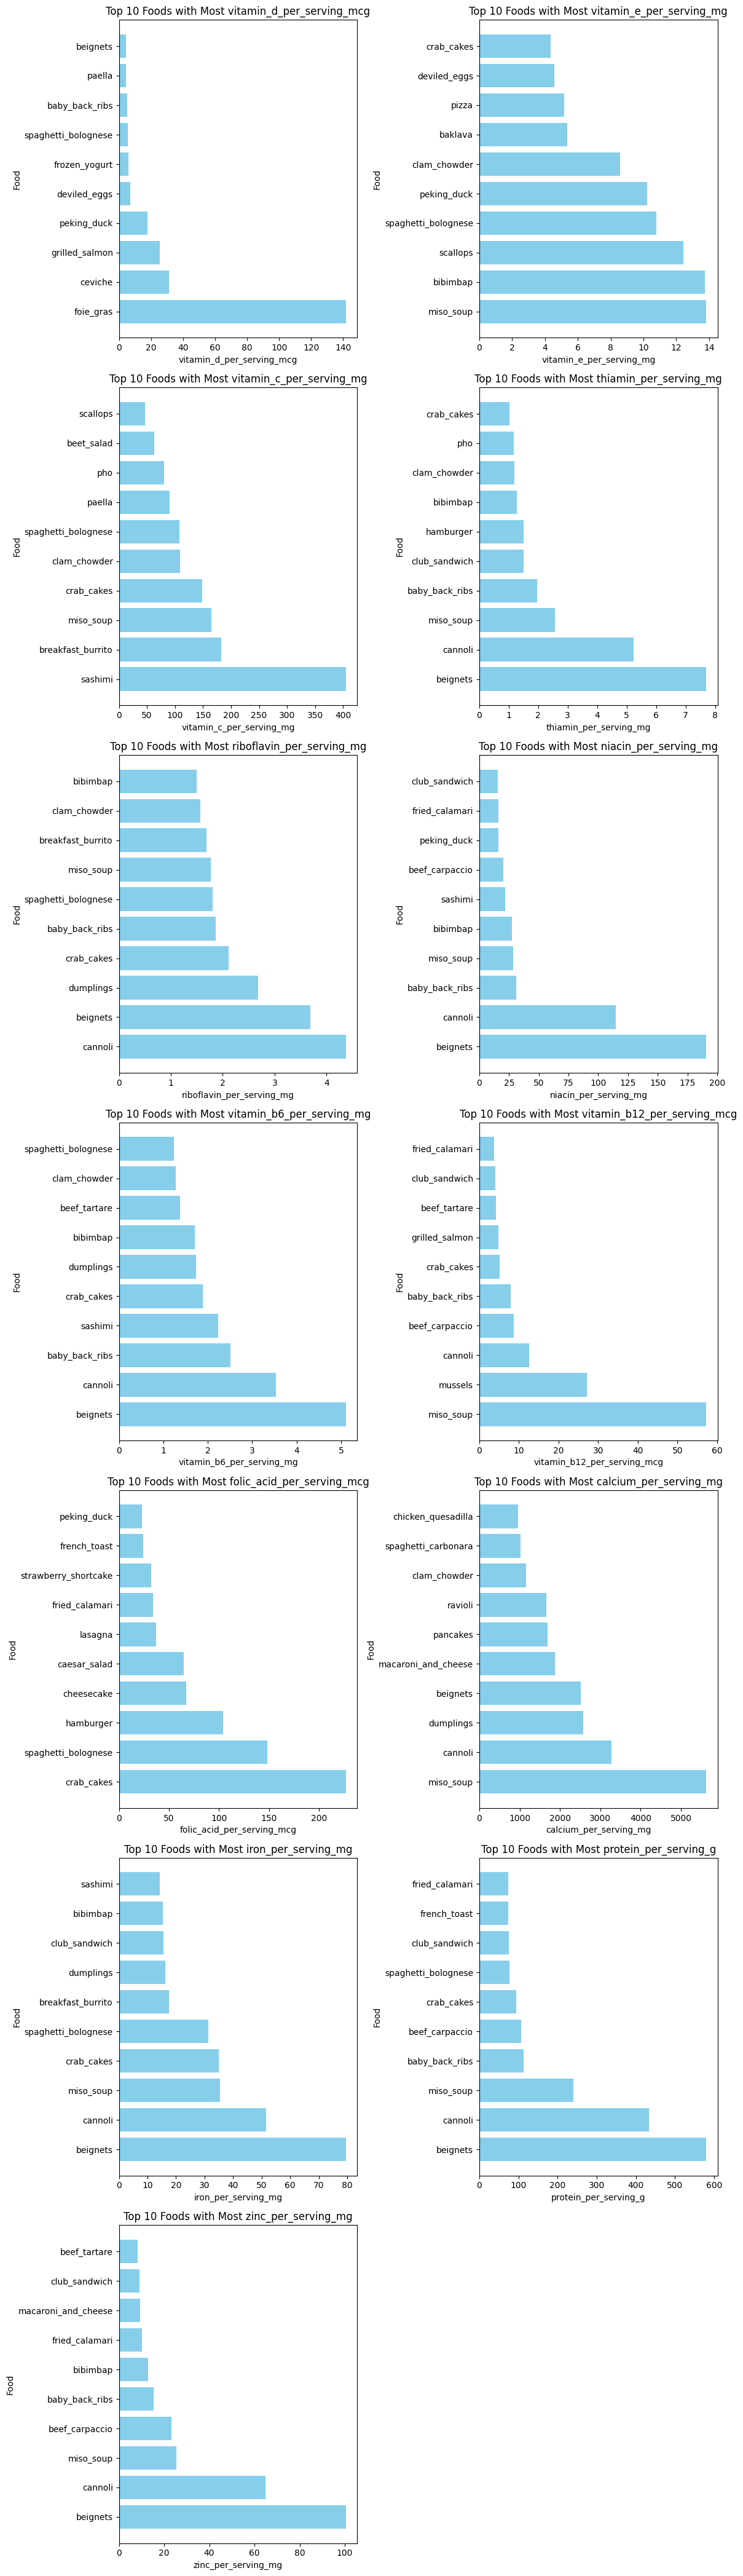

In [13]:
import matplotlib.pyplot as plt

final_df.drop(columns=['Unnamed: 0'], inplace=True)

nutrient_columns = final_df.columns[2:]

num_rows = 7
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

axs = axs.flatten()

for i, nutrient in enumerate(nutrient_columns):
    top_10_foods = final_df.sort_values(by=nutrient, ascending=False).head(10)
    
    axs[i].barh(top_10_foods['Classes'], top_10_foods[nutrient], color='skyblue')
    axs[i].set_xlabel(nutrient)  
    axs[i].set_ylabel('Food')    
    axs[i].set_title(f'Top 10 Foods with Most {nutrient}')  
axs[-1].set_visible(False)
plt.tight_layout()

plt.show()

#### It is also intereing to see the heatmap showing the correlation among the nutritions. We can see that protein, zinc and iron are highly correlated in foods. Also protein, zinc and iron are highly correlated with thiamin, riboflavin, niacin, and vitamin b6.

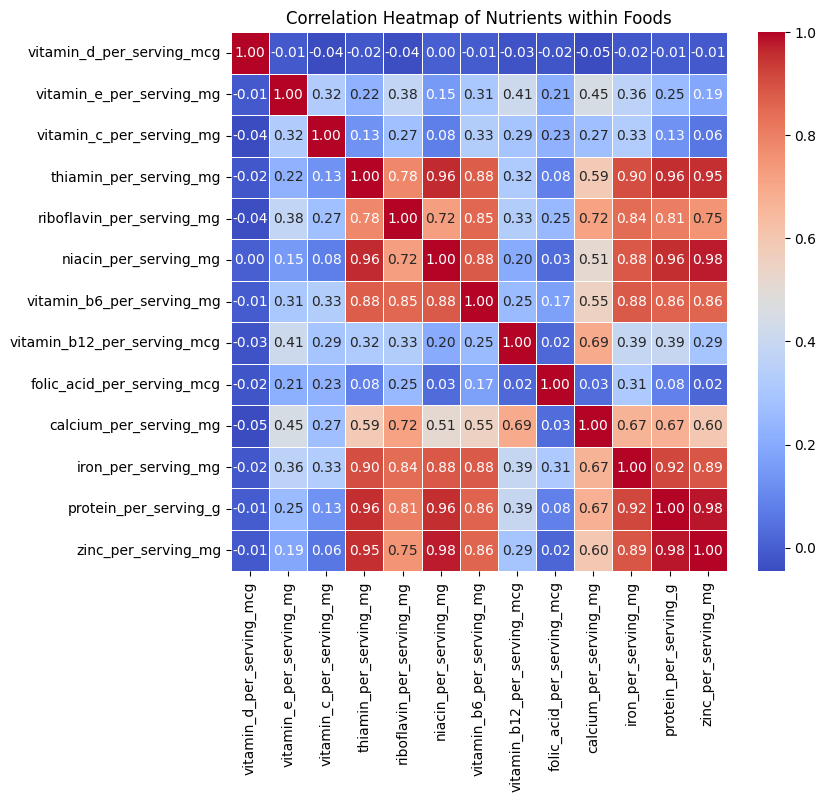

In [16]:
import seaborn as sns


# Calculate the correlation matrix
correlation_matrix = final_df.iloc[:, 2:].corr()

plt.figure(figsize=(8, 7))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap of Nutrients within Foods')
plt.show()